### Read Events

In [38]:
from pathlib import Path
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import datetime

def read_tfevent_files_as_dataframe(log_dir):
    """
    Reads all tfevents files from a directory and extracts metrics into a single DataFrame.

    Args:
        log_dir (str): Directory containing tfevents files.

    Returns:
        pd.DataFrame: DataFrame containing 'metric_name', 'timestamp', 'step', and 'value'.
    """
    data = []
    log_dir = Path(log_dir)
    event_files = list(log_dir.glob('events.out.tfevents.*'))

    for file_path in event_files:
        try:
            event_acc = EventAccumulator(str(file_path))
            event_acc.Reload()
            available_tags = event_acc.Tags().get('scalars', [])

            for metric in available_tags:
                events = event_acc.Scalars(metric)
                for event in events:
                    # Convert wall_time to datetime
                    timestamp = datetime.datetime.fromtimestamp(event.wall_time)
                    data.append({
                        'metric_name': metric,
                        'timestamp': timestamp,
                        'step': event.step,
                        'value': event.value
                    })

        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
            return  pd.DataFrame()

    # Create DataFrame
    df = pd.DataFrame(data)

    start_time = df['timestamp'].iloc[0]
    df['relative_time'] = (df['timestamp'] - start_time).dt.total_seconds() / 60  # Convert to minutes

    # Ensure sorting by metric_name and step for consistent plotting
    df = df.sort_values(by=['metric_name', 'step']).reset_index(drop=True)

    return df

# Get dataframe

In [85]:
df = read_tfevent_files_as_dataframe("logs/DQN_0")

### Plot1

In [43]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_metric(df, metric_name, use_time=True, figsize=(8, 6), save_path=None, last_n_minutes=None,):
    """
    Visualize a specific metric using matplotlib. Option to display time or steps on the x-axis.

    Args:
        df (pd.DataFrame): DataFrame containing the metrics.
        metric_name (str): The metric to visualize (e.g., 'reward', 'loss').
        use_time (bool): If True, use timestamps on the x-axis. If False, use steps.
        figsize (tuple): The size of the figure.
        save_path (str, optional): If provided, saves the plot to the specified path.

    Returns:
        None
    """
    # Filter data for the selected metric
    metric_data = df[df['metric_name'] == metric_name]

    # Filter for the last n minutes if requested
    if last_n_minutes is not None:
        # Get the maximum relative time (latest timestamp)
        max_time = metric_data['relative_time'].max()

        # Filter to include only the last n minutes
        metric_data = metric_data[metric_data['relative_time'] >= (max_time - last_n_minutes)]

    # Set up the plot
    plt.figure(figsize=figsize)

    # Choose x-axis data: either timestamps or steps
    if use_time:
        # plt.plot(metric_data['timestamp'], metric_data['value'], label=metric_name, color='tab:blue')

        # Formatting time on x-axis for better readability
        # plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
        # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        # plt.gca().xaxis.set_minor_locator(mdates.MinuteLocator(interval=15))
        # plt.gcf().autofmt_xdate()  # Rotate date labels
        plt.plot(metric_data['relative_time'], metric_data['value'], label=metric_name, color='tab:blue')
        plt.xlabel('Time (minutes)', fontsize=14)
    else:
        plt.plot(metric_data['step'], metric_data['value'], label=metric_name, color='tab:blue')

    # Adding labels and title
    plt.title(f"{metric_name.capitalize()} over Time" if use_time else f"{metric_name.capitalize()} over Steps", fontsize=16)
    plt.xlabel('Time' if use_time else 'Steps', fontsize=14)
    plt.ylabel(f'{metric_name.capitalize()}', fontsize=14)

    # Improve appearance
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()

    # Optionally save the plot
    if save_path:
        plt.savefig(save_path, dpi=300)  # High resolution for paper publishing
    else:
        plt.show()


### Test out

In [86]:
df['metric_name'].value_counts()

metric_name
rollout/exploration_rate    2308
train/learning_rate         2296
train/loss                  2296
episode/score               2295
episode/lines_cleared       2295
episode/pieces_placed       2295
eval/mean_ep_length         1167
eval/mean_reward            1167
rollout/ep_len_mean         1141
rollout/ep_rew_mean         1141
time/fps                    1141
episode/holes                387
episode/bumpiness            387
Name: count, dtype: int64

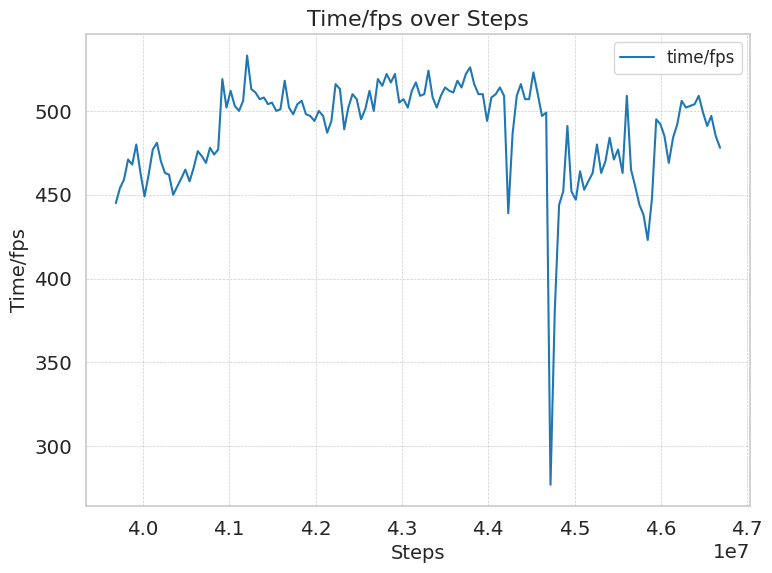

In [87]:
plot_metric(df, 'time/fps', use_time=False, last_n_minutes=240)

### Plot2

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_metric_seaborn(df, metric_name, use_time=True, last_n_minutes=None, figsize=(8, 6), save_path=None):
    """
    Visualize a specific metric using Seaborn and Matplotlib. Option to display relative time (T+time) or steps on the x-axis.
    Can also zoom in on the last n minutes of data.

    Args:
        df (pd.DataFrame): DataFrame containing the metrics.
        metric_name (str): The metric to visualize (e.g., 'reward', 'loss').
        use_time (bool): If True, use timestamps on the x-axis as relative time (T+time). If False, use steps.
        last_n_minutes (int, optional): If specified, only display the last n minutes of data.
        figsize (tuple): The size of the figure.
        save_path (str, optional): If provided, saves the plot to the specified path.

    Returns:
        None
    """
    # Set Seaborn style
    sns.set(style="whitegrid", palette="muted", font_scale=1.3)

    # Filter data for the selected metric
    metric_data = df[df['metric_name'] == metric_name]

    # Filter for the last n minutes if requested
    if last_n_minutes is not None:
        # Get the maximum relative time (latest timestamp)
        max_time = metric_data['relative_time'].max()

        # Filter to include only the last n minutes
        metric_data = metric_data[metric_data['relative_time'] >= (max_time - last_n_minutes)]

    # Set up the plot
    plt.figure(figsize=figsize)

    # Choose x-axis data: either relative time (T+time) or steps
    if use_time:
        sns.lineplot(x='relative_time', y='value', data=metric_data, label=metric_name, color='tab:blue')
        plt.xlabel('Time (minutes)', fontsize=14)
    else:
        sns.lineplot(x='step', y='value', data=metric_data, label=metric_name, color='tab:blue')
        plt.xlabel('Steps', fontsize=14)

    # Adding labels and title
    plt.title(f"{metric_name.capitalize()} over Time" if use_time else f"{metric_name.capitalize()} over Steps", fontsize=16)
    plt.ylabel(f'{metric_name.capitalize()}', fontsize=14)

    # Optionally save the plot
    if save_path:
        plt.savefig(save_path, dpi=300)  # High resolution for paper publishing
    else:
        plt.show()

### Use the plot

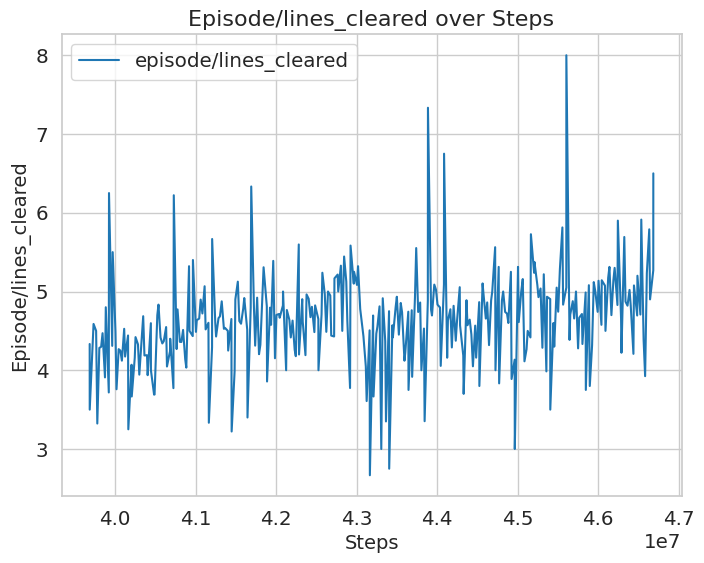

In [94]:
plot_metric_seaborn(df, 'episode/lines_cleared', use_time=False, last_n_minutes=240)

### Plot3

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter

def plot_metric_seaborn2(df, metric_name, use_time=True, last_n_minutes=None, smoothing='rolling', window_size=5, figsize=(8, 6), save_path=None):
    """
    Visualize a specific metric using Seaborn and Matplotlib. Option to display relative time (T+time) or steps on the x-axis.
    Can also zoom in on the last n minutes of data. Optionally apply smoothing to the data.

    Args:
        df (pd.DataFrame): DataFrame containing the metrics.
        metric_name (str): The metric to visualize (e.g., 'reward', 'loss').
        use_time (bool): If True, use timestamps on the x-axis as relative time (T+time). If False, use steps.
        last_n_minutes (int, optional): If specified, only display the last n minutes of data.
        smoothing (str): Type of smoothing to apply. Options are 'rolling', 'EMA', 'savgol'.
        window_size (int): The window size for smoothing (e.g., 5, 10, etc.).
        figsize (tuple): The size of the figure.
        save_path (str, optional): If provided, saves the plot to the specified path.

    Returns:
        None
    """
    # Set Seaborn style
    sns.set(style="whitegrid", palette="muted", font_scale=1.3)

    # Filter data for the selected metric
    metric_data = df[df['metric_name'] == metric_name]

    # Filter for the last n minutes if requested
    if last_n_minutes is not None:
        # Get the maximum relative time (latest timestamp)
        max_time = metric_data['relative_time'].max()

        # Filter to include only the last n minutes
        metric_data = metric_data[metric_data['relative_time'] >= (max_time - last_n_minutes)]

    # Apply smoothing based on the specified method
    if smoothing == 'rolling':
        metric_data['smoothed'] = metric_data['value'].rolling(window=window_size, min_periods=1).mean()
    elif smoothing == 'EMA':
        metric_data['smoothed'] = metric_data['value'].ewm(span=window_size, adjust=False).mean()
    elif smoothing == 'savgol':
        metric_data['smoothed'] = savgol_filter(metric_data['value'], window_length=window_size, polyorder=2)

    # Set up the plot
    plt.figure(figsize=figsize)

    # Choose x-axis data: either relative time (T+time) or steps
    if use_time:
        # sns.lineplot(x='relative_time', y='value', data=metric_data, label=f'{metric_name} (raw)', color='tab:blue')
        sns.lineplot(x='relative_time', y='smoothed', data=metric_data, label=f'{metric_name} (smoothed)', color='tab:orange')
        plt.xlabel('Time (minutes)', fontsize=14)
    else:
        # sns.lineplot(x='step', y='value', data=metric_data, label=f'{metric_name} (raw)', color='tab:blue')
        sns.lineplot(x='step', y='smoothed', data=metric_data, label=f'{metric_name} (smoothed)', color='tab:orange')
        plt.xlabel('Steps', fontsize=14)

    # Adding labels and title
    plt.title(f"{metric_name.capitalize()} over Time" if use_time else f"{metric_name.capitalize()} over Steps", fontsize=16)
    plt.ylabel(f'{metric_name.capitalize()}', fontsize=14)

    # Show legend
    plt.legend()

    # Optionally save the plot
    if save_path:
        plt.savefig(save_path, dpi=300)  # High resolution for paper publishing
    else:
        plt.show()


### Use plot3

/tmp/ipykernel_1736214/4121376731.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metric_data['smoothed'] = metric_data['value'].ewm(span=window_size, adjust=False).mean()


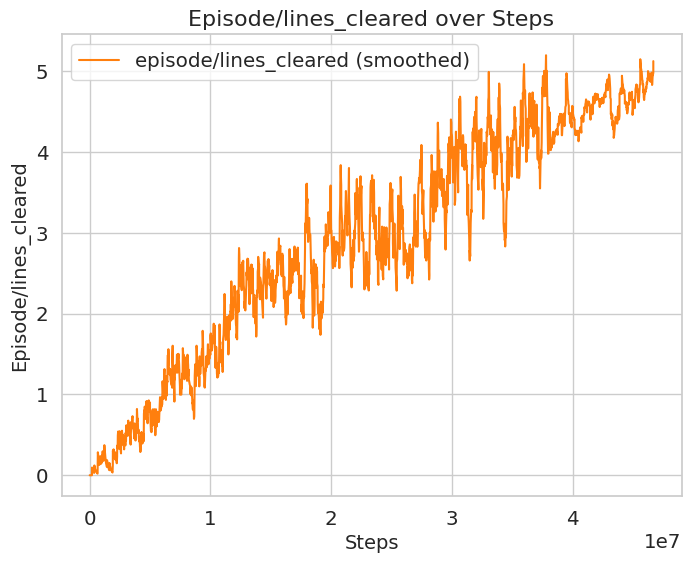

In [91]:
# plot_metric_seaborn2(df, 'episode/pieces_placed', use_time=False, last_n_minutes=None, smoothing="EMA", window_size=20)
# plot_metric_seaborn2(df, 'episode/score', use_time=False, last_n_minutes=None, smoothing="EMA", window_size=20)
plot_metric_seaborn2(df, 'episode/lines_cleared', use_time=False, last_n_minutes=None, smoothing="EMA", window_size=20)